In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Load MinWage variable

In [19]:
data = pd.read_csv("./minimum wage.csv") 
data['Effective Date'] = pd.to_datetime(data['Effective Date'], format='%d-%b-%y')
data = data.sort_values(by='Effective Date')

data['Minimum Wage'] = data['Minimum Wage'].replace('[\$,]', '', regex=True).astype(float)

monthly_range = pd.date_range(start='2003-01-01', end='2024-09-01', freq='MS')
monthly_df = pd.DataFrame({'date': monthly_range})

data = data.set_index('Effective Date')
monthly_df = monthly_df.merge(data[['Minimum Wage']], how='left', left_on='date', right_index=True)

monthly_df['MinWage'] = monthly_df['Minimum Wage'].ffill().bfill()

monthly_df.loc[monthly_df['date'] < '2011-05-01', 'MinWage'] = 8.00

monthly_df = monthly_df.drop(columns=['Minimum Wage'])

monthly_df.head(1000)

,date,MinWage
0,2003-01-01,8.00
1,2003-02-01,8.00
2,2003-03-01,8.00
3,2003-04-01,8.00
4,2003-05-01,8.00
...,...,...
256,2024-05-01,16.75
257,2024-06-01,17.40
258,2024-07-01,17.40
259,2024-08-01,17.40


## load crime_number variable

In [20]:
crime_data = pd.read_csv("./crimedata_csv_AllNeighbourhoods_AllYears/crimedata_csv_AllNeighbourhoods_AllYears.csv")  # Replace with the actual path

crime_data['date'] = pd.to_datetime(crime_data[['YEAR', 'MONTH']].assign(DAY=1))

monthly_crime_counts = crime_data.groupby('date').size().reset_index(name='crime_number')

monthly_df = monthly_df.merge(monthly_crime_counts, how='left', on='date')

monthly_df['crime_number'] = monthly_df['crime_number'].fillna(0)

monthly_df.head(1000)




,date,MinWage,crime_number
0,2003-01-01,8.00,4926
1,2003-02-01,8.00,4148
2,2003-03-01,8.00,4550
3,2003-04-01,8.00,4759
4,2003-05-01,8.00,5297
...,...,...,...
256,2024-05-01,16.75,3007
257,2024-06-01,17.40,2810
258,2024-07-01,17.40,3053
259,2024-08-01,17.40,2977


In [21]:
cpi_data = pd.read_csv("./1810000601-eng (1).csv", header=0, index_col=0)

cpi_data = cpi_data.T

cpi_data = cpi_data.rename(columns={"All-items 8": "CPI"})

cpi_data = cpi_data.reset_index().rename(columns={"index": "date"})
cpi_data['date'] = pd.to_datetime(cpi_data['date'], format='%b-%y')

cpi_data = cpi_data[['date', 'CPI']]

cpi_data.index.name = "index"

monthly_df = monthly_df.merge(cpi_data, how='left', on='date')

monthly_df.head(1000)

,date,MinWage,crime_number,CPI
0,2003-01-01,8.00,4926,102.4
1,2003-02-01,8.00,4148,102.9
2,2003-03-01,8.00,4550,103.0
3,2003-04-01,8.00,4759,102.3
4,2003-05-01,8.00,5297,102.1
...,...,...,...,...
256,2024-05-01,16.75,3007,160.6
257,2024-06-01,17.40,2810,160.8
258,2024-07-01,17.40,3053,161.2
259,2024-08-01,17.40,2977,161.3


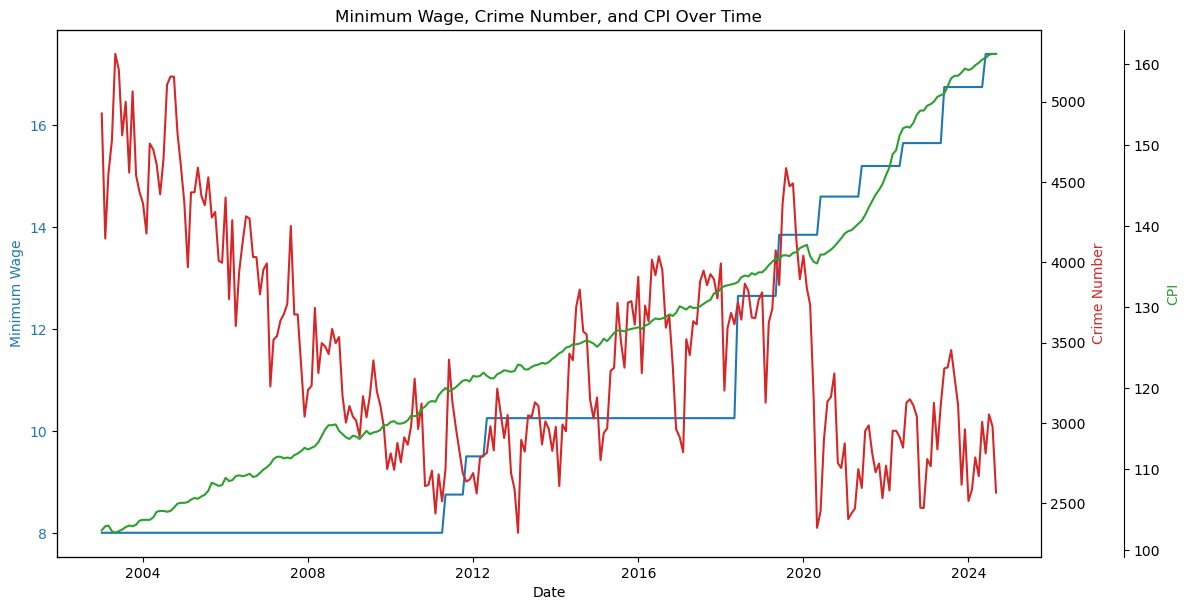

In [22]:
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Minimum Wage', color=color)
ax1.plot(monthly_df['date'], monthly_df['MinWage'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'

ax2.set_ylabel('Crime Number', color=color)
ax2.plot(monthly_df['date'], monthly_df['crime_number'], color=color)

ax3 = ax1.twinx()
color = 'tab:green'
ax3.spines['right'].set_position(('outward', 60))
ax3.set_ylabel('CPI', color=color)
ax3.plot(monthly_df['date'], monthly_df['CPI'], color=color)

fig.tight_layout()
plt.title('Minimum Wage, Crime Number, and CPI Over Time')
plt.show()


## Load temperature variable

In [23]:
temperature_data = pd.read_csv("./temperature.csv", header=None, names=["date", "temperature"])

temperature_data['date'] = pd.to_datetime(temperature_data['date'], format='%Y-%m-%d')

merged_df = pd.merge(monthly_df, temperature_data, how='left', on='date')

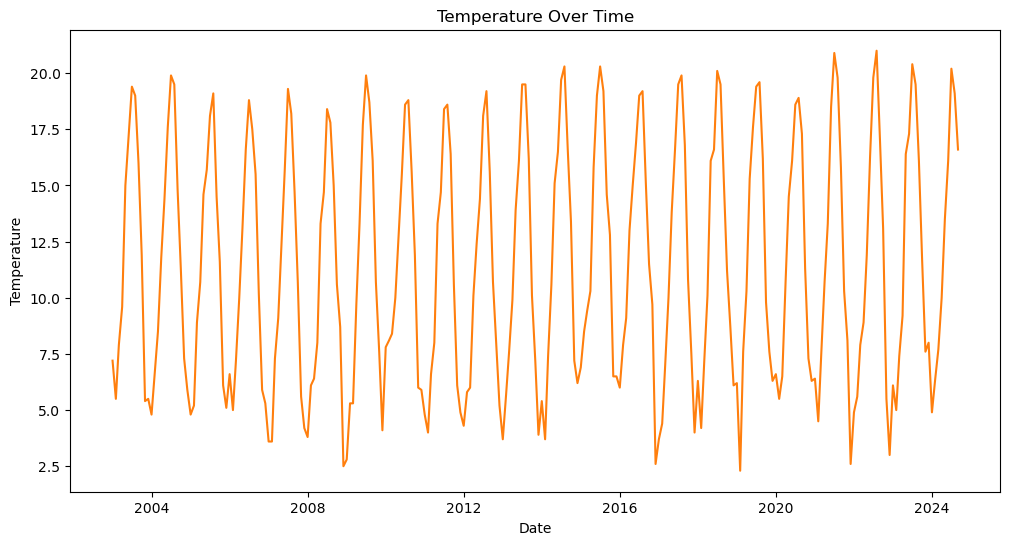

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(merged_df['date'], merged_df['temperature'], color='tab:orange')
plt.title('Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.show()


## Loaded police officer ratio and weighted clearance rate

In [25]:
police_data = pd.read_csv("./unemployment_police.csv")  

police_data['Date'] = pd.to_datetime(police_data['Date'])

police_data.rename(columns={'Date': 'date'}, inplace=True)

merged_df = pd.merge(merged_df, police_data, how='left', on='date')

merged_df.head()

,date,MinWage,crime_number,CPI,temperature,"Police officers per 100,000 population",Weighted clearance rate,Vancouver Unemployment Rate
0,2003-01-01,8.0,4926,102.4,7.2,204.2,22.74,7.1
1,2003-02-01,8.0,4148,102.9,5.5,204.2,22.74,7.1
2,2003-03-01,8.0,4550,103.0,7.9,204.2,22.74,7.0
3,2003-04-01,8.0,4759,102.3,9.6,204.2,22.74,7.3
4,2003-05-01,8.0,5297,102.1,15.0,204.2,22.74,7.3


In [26]:
# print the average of crime number, minimum wage, CPI, temperature, unemployment rate, and police number
print("Average of crime number: ", merged_df['crime_number'].mean())
print("Average of minimum wage: ", merged_df['MinWage'].mean())
print("Average of CPI: ", merged_df['CPI'].mean())
print("Average of temperature: ", merged_df['temperature'].mean())

Average of crime number:  3434.015325670498
Average of minimum wage:  10.696360153256707
Average of CPI:  125.5800766283525
Average of temperature:  11.418773946360155


In [27]:
import pandas as pd

# Function to generate a data description table for all variables
def generate_data_description(df):
    # Basic Statistics using describe()
    stats = df.describe(include='all').transpose()

    # Count unique values
    stats['unique_values'] = df.nunique()

    # Reorder columns for clarity
    stats = stats[['count', 'unique_values', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]
    
    # Rename index to column names
    stats.index.name = 'column_name'

    return stats

# Generate the data description table for merged_df
data_description = generate_data_description(merged_df)

# Display the data description table
data_description


/var/folders/qx/5b_gxq5s5fqc9hdq8fcjn60h0000gn/T/ipykernel_60417/2984029029.py:6: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  stats = df.describe(include='all').transpose()


,count,unique_values,mean,std,min,25%,50%,75%,max
column_name,,,,,,,,,
date,261,261,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MinWage,261.0,11,10.69636,2.960168,8.0,8.0,10.25,12.65,17.4
crime_number,261.0,245,3434.015326,672.739325,2316.0,2913.0,3310.0,3867.0,5297.0
CPI,261.0,206,125.580077,15.707729,102.1,113.7,123.2,135.4,161.3
temperature,261.0,136,11.418774,5.351577,2.3,6.5,10.6,16.2,21.0
"Police officers per 100,000 population",261.0,20,204.136782,15.397368,183.8,191.5,199.1,216.9,234.4
Weighted clearance rate,261.0,19,26.333678,2.262443,22.74,24.53,25.33,27.62,30.85
Vancouver Unemployment Rate,261.0,56,6.164368,1.572723,3.2,4.8,6.5,7.0,14.2


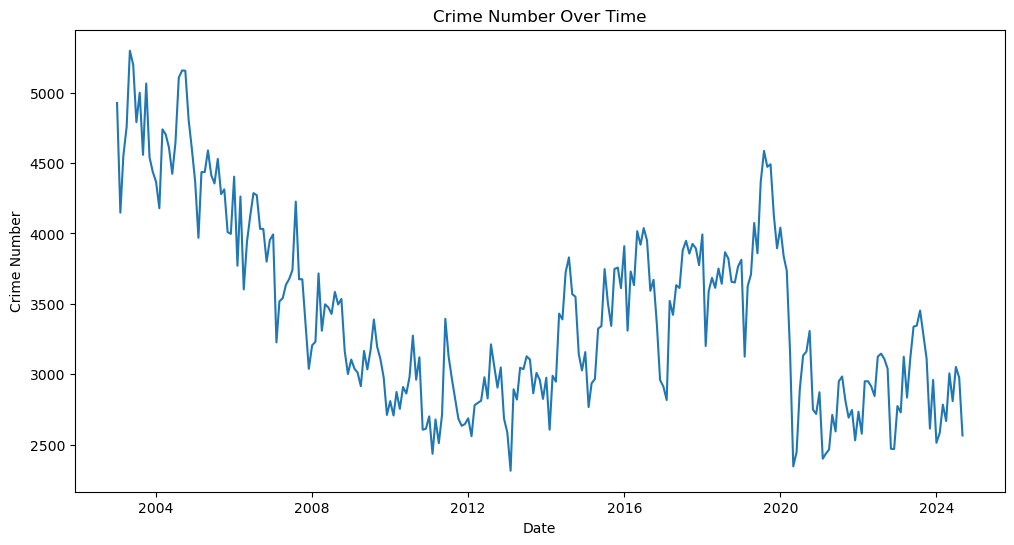

In [34]:
# plot the crime number data over time
plt.figure(figsize=(12, 6))
plt.plot(merged_df['date'], merged_df['crime_number'], color='tab:blue')
plt.title('Crime Number Over Time')
plt.xlabel('Date')
plt.ylabel('Crime Number')
plt.show()

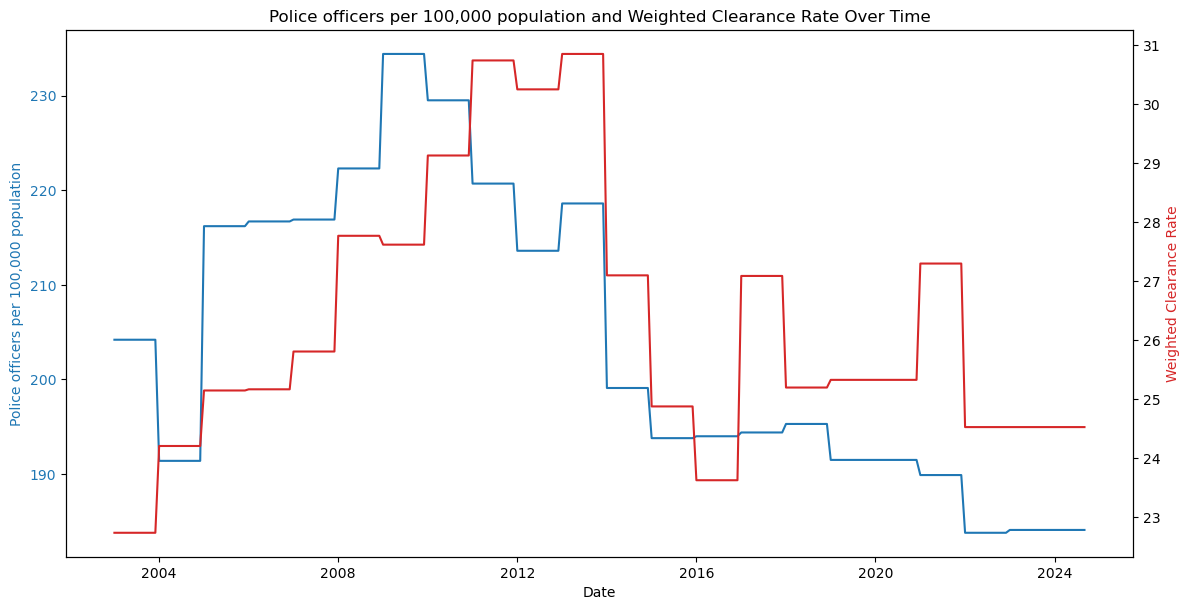

In [28]:
# visualize Police officers per 100,000 population and weighted clearance rate over time
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Police officers per 100,000 population', color=color)
ax1.plot(merged_df['date'], merged_df['Police officers per 100,000 population'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'

ax2.set_ylabel('Weighted Clearance Rate', color=color)
ax2.plot(merged_df['date'], merged_df['Weighted clearance rate'], color=color)

fig.tight_layout()
plt.title('Police officers per 100,000 population and Weighted Clearance Rate Over Time')
plt.show()

In [29]:
merged_df_arima = merged_df.copy()
merged_df_xgb = merged_df.copy()

## Method 1: SARIMA 

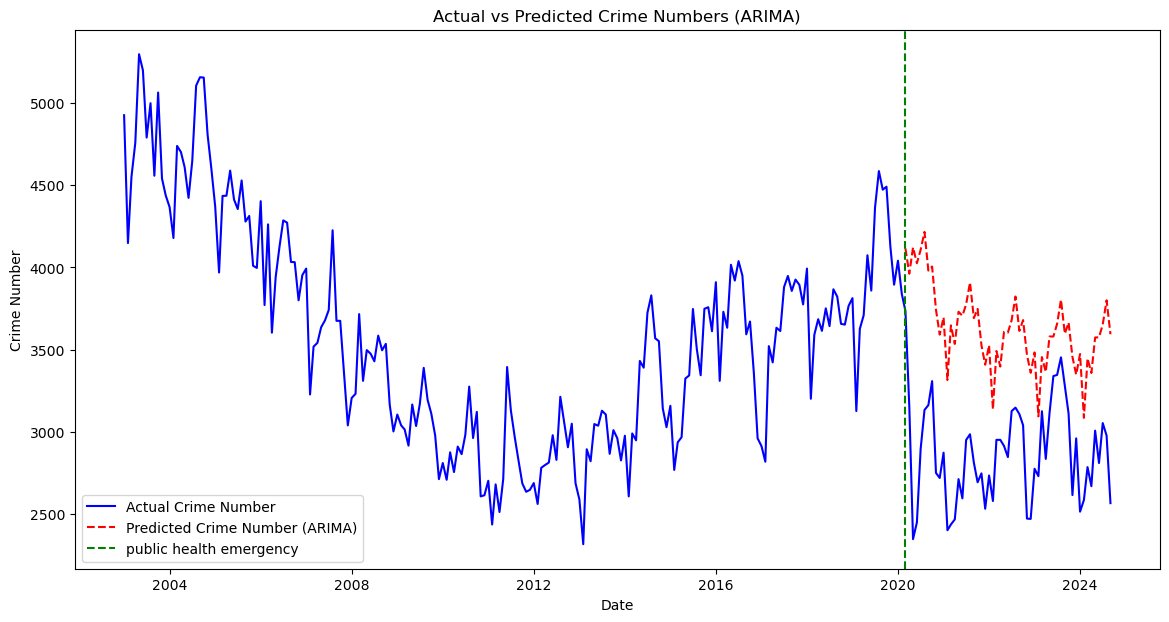

          date  crime_number  predicted_crime_number_arima  \
256 2024-05-01          3007                   3573.896268   
257 2024-06-01          2810                   3574.569717   
258 2024-07-01          3053                   3652.427101   
259 2024-08-01          2977                   3799.693502   
260 2024-09-01          2566                   3593.305668   

     crime_difference_arima  
256             -566.896268  
257             -764.569717  
258             -599.427101  
259             -822.693502  
260            -1027.305668  


In [30]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Step 1: Filter data to include only dates before October 17, 2018
pre_legalization_data_arima = merged_df_arima[merged_df_arima['date'] < '2020-03-01']
crime_series_arima = pre_legalization_data_arima.set_index('date')['crime_number']
crime_series_arima = crime_series_arima.asfreq('MS')

# Step 2: Define and fit the SARIMA model
model_arima = SARIMAX(crime_series_arima, order=(1, 0, 0), seasonal_order=(1, 1, 1, 12))
sarima_model = model_arima.fit(disp=False)

# Step 3: Forecast crime numbers from October 2018 to the end of the dataset
forecast_start = '2020-03-01'
forecast_end = merged_df_arima['date'].max()
forecast_arima = sarima_model.predict(start=forecast_start, end=forecast_end, dynamic=True)

# Step 4: Convert forecast to DataFrame and merge back with merged_df_arima
forecast_df_arima = forecast_arima.reset_index()
forecast_df_arima.columns = ['date', 'predicted_crime_number_arima']
merged_df_arima = pd.merge(merged_df_arima, forecast_df_arima, how='left', on='date')

# Step 5: Plot actual vs. predicted crime numbers using only merged_df_arima
legalization_date = pd.to_datetime('2020-03-01')
plt.figure(figsize=(14, 7))
plt.plot(merged_df_arima['date'], merged_df_arima['crime_number'], label="Actual Crime Number", color="blue")
plt.plot(merged_df_arima['date'], merged_df_arima['predicted_crime_number_arima'], label="Predicted Crime Number (ARIMA)", color="red", linestyle="--")
plt.axvline(x=legalization_date, color='green', linestyle='--', label='public health emergency')
plt.xlabel("Date")
plt.ylabel("Crime Number")
plt.title("Actual vs Predicted Crime Numbers (ARIMA)")
plt.legend()
plt.show()

# Step 6: Calculate and print the difference to quantify the impact
merged_df_arima['crime_difference_arima'] = merged_df_arima['crime_number'] - merged_df_arima['predicted_crime_number_arima']
print(merged_df_arima[['date', 'crime_number', 'predicted_crime_number_arima', 'crime_difference_arima']].tail(5))


In [31]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(crime_series_arima)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -1.7802611905099717
p-value: 0.3903045572939163


## Method 2: XGBoost

/var/folders/qx/5b_gxq5s5fqc9hdq8fcjn60h0000gn/T/ipykernel_60417/1562246812.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)
/var/folders/qx/5b_gxq5s5fqc9hdq8fcjn60h0000gn/T/ipykernel_60417/1562246812.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)
/var/folders/qx/5b_gxq5s5fqc9hdq8fcjn60h0000gn/T/ipykernel_60417/1562246812.py:7: SettingWithCopyWarning: 
A value is trying to be set on a 

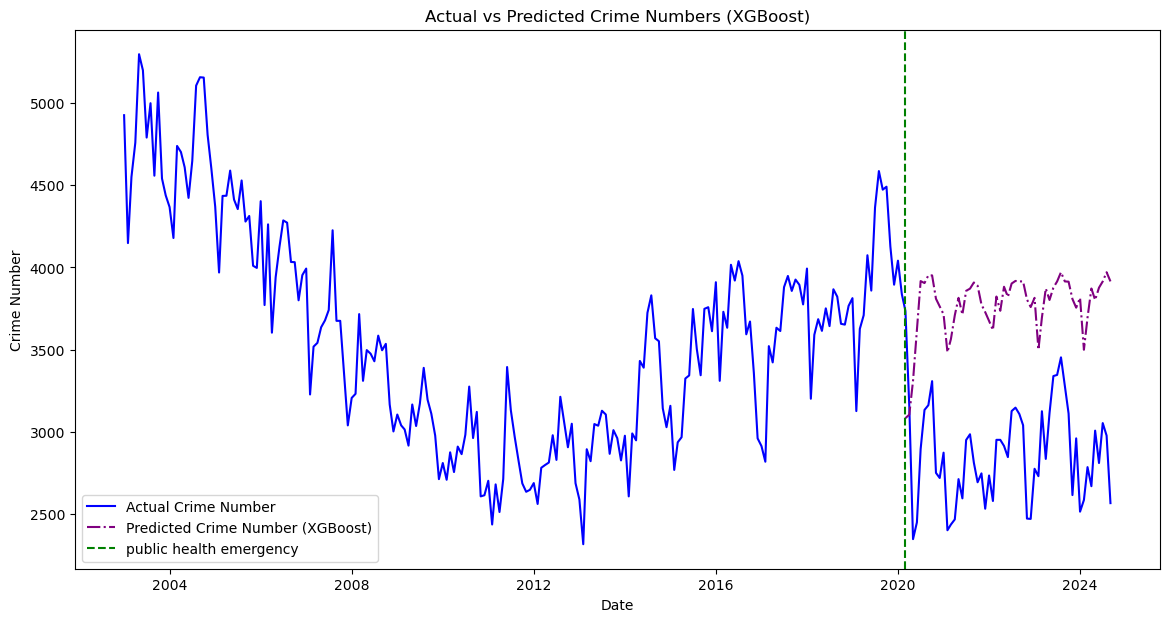

          date  crime_number  predicted_crime_number_xgb  crime_difference_xgb
256 2024-05-01          3007                 3801.883789           -794.883789
257 2024-06-01          2810                 3876.635742          -1066.635742
258 2024-07-01          3053                 3914.600586           -861.600586
259 2024-08-01          2977                 3970.723633           -993.723633
260 2024-09-01          2566                 3914.860352          -1348.860352


In [32]:
import xgboost as xgb

pre_legalization_data_xgb = merged_df_xgb[merged_df_xgb['date'] < '2020-03-01']

def create_lagged_features(df, target_col, lags):
    for lag in range(1, lags + 1):
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)
    return df

pre_legalization_data_xgb = create_lagged_features(pre_legalization_data_xgb, 'crime_number', 3)
pre_legalization_data_xgb = pre_legalization_data_xgb.dropna()

pre_legalization_data_xgb['month'] = pre_legalization_data_xgb['date'].dt.month
pre_legalization_data_xgb['year'] = pre_legalization_data_xgb['date'].dt.year

X_train_xgb = pre_legalization_data_xgb[
    ['crime_number_lag_1', 'crime_number_lag_2', 'crime_number_lag_3', 
     'month', 'year', 
     'Police officers per 100,000 population', 
     'Weighted clearance rate', 
     'Vancouver Unemployment Rate', 
     'CPI', 'MinWage']
]
y_train_xgb = pre_legalization_data_xgb['crime_number']

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train_xgb, y_train_xgb)

post_legalization_data_xgb = merged_df_xgb[merged_df_xgb['date'] >= '2020-03-01'].copy()
post_legalization_data_xgb = create_lagged_features(post_legalization_data_xgb, 'crime_number', 3)

post_legalization_data_xgb['month'] = post_legalization_data_xgb['date'].dt.month
post_legalization_data_xgb['year'] = post_legalization_data_xgb['date'].dt.year

predictions = []

for i in range(len(post_legalization_data_xgb)):
    X_pred = post_legalization_data_xgb[
        ['crime_number_lag_1', 'crime_number_lag_2', 'crime_number_lag_3', 
         'month', 'year', 
         'Police officers per 100,000 population', 
         'Weighted clearance rate', 
         'Vancouver Unemployment Rate', 
         'CPI', 'MinWage']
    ].iloc[i].values.reshape(1, -1)
    
    pred = xgb_model.predict(X_pred)[0]
    predictions.append(pred)
    
    # Update lagged values with the prediction for subsequent rows
    if i + 1 < len(post_legalization_data_xgb):
        post_legalization_data_xgb.loc[post_legalization_data_xgb.index[i + 1], 'crime_number_lag_1'] = pred
        post_legalization_data_xgb.loc[post_legalization_data_xgb.index[i + 1], 'crime_number_lag_2'] = post_legalization_data_xgb.loc[post_legalization_data_xgb.index[i], 'crime_number_lag_1']
        post_legalization_data_xgb.loc[post_legalization_data_xgb.index[i + 1], 'crime_number_lag_3'] = post_legalization_data_xgb.loc[post_legalization_data_xgb.index[i], 'crime_number_lag_2']

post_legalization_data_xgb['predicted_crime_number_xgb'] = predictions
merged_df_xgb = pd.merge(merged_df_xgb, post_legalization_data_xgb[['date', 'predicted_crime_number_xgb']], how='left', on='date')

legalization_date = pd.to_datetime('2020-03-01')
plt.figure(figsize=(14, 7))
plt.plot(merged_df_xgb['date'], merged_df_xgb['crime_number'], label="Actual Crime Number", color="blue")
plt.plot(merged_df_xgb['date'], merged_df_xgb['predicted_crime_number_xgb'], label="Predicted Crime Number (XGBoost)", color="purple", linestyle="-.")
plt.axvline(x=legalization_date, color='green', linestyle='--', label='public health emergency')
plt.xlabel("Date")
plt.ylabel("Crime Number")
plt.title("Actual vs Predicted Crime Numbers (XGBoost)")
plt.legend()
plt.show()

merged_df_xgb['crime_difference_xgb'] = merged_df_xgb['crime_number'] - merged_df_xgb['predicted_crime_number_xgb']
print(merged_df_xgb[['date', 'crime_number', 'predicted_crime_number_xgb', 'crime_difference_xgb']].tail(5))


1. continues prediction
2. validation